<a href="https://colab.research.google.com/github/adonapati/GenAI-Remote-Sensing/blob/main/Copy_of_Unetr_Implementation_on_Figshare_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import tensorflow as tf
from numba import cuda

cuda.select_device(0)
cuda.close()

tf.keras.backend.clear_session()

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
path = kagglehub.dataset_download("samvram/sarfloodsegmentation")

print('Data source import complete.')
print(path)

Data source import complete.
/root/.cache/kagglehub/datasets/samvram/sarfloodsegmentation/versions/1


In [2]:
!pip install monai

In [3]:
from glob import glob
from matplotlib import pyplot as plt
import numpy as np
import os
from skimage.io import imread

In [4]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

# helper function for data visualization
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x


In [5]:
def get_train_datapath():
    return glob('/root/.cache/kagglehub/datasets/samvram/sarfloodsegmentation/versions/1/train/train/*/*/flood_label/*.png')[:1000]

def get_val_datapath():
    return glob('/root/.cache/kagglehub/datasets/samvram/sarfloodsegmentation/versions/1/val_with_ref_labels/test/*/*/flood_label/*.png')[:100]

def cvtFpath(fpath, label):
    if label in ['vv', 'vh']:
        return '/'.join([tag if tag!='flood_label' else label for tag in fpath.split('/')])[:-4]+'_%s.png'%label
    else:
        return '/'.join([tag if tag!='flood_label' else label for tag in fpath.split('/')])

train_paths = get_train_datapath()
val_paths = get_val_datapath()

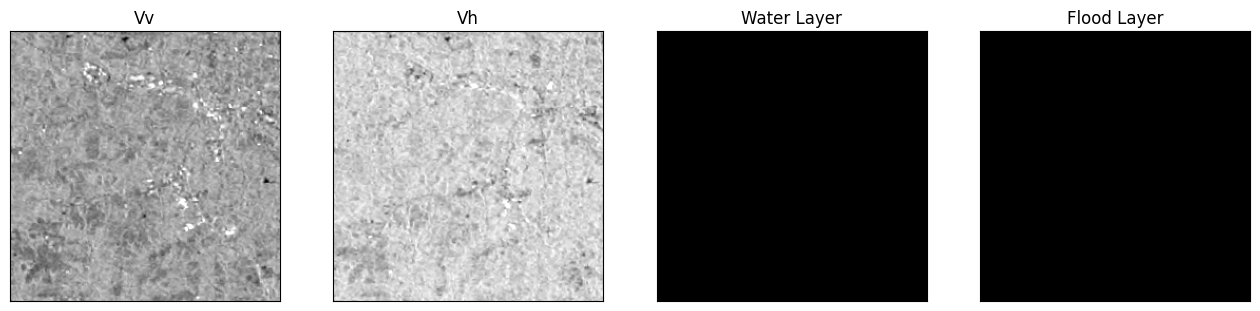

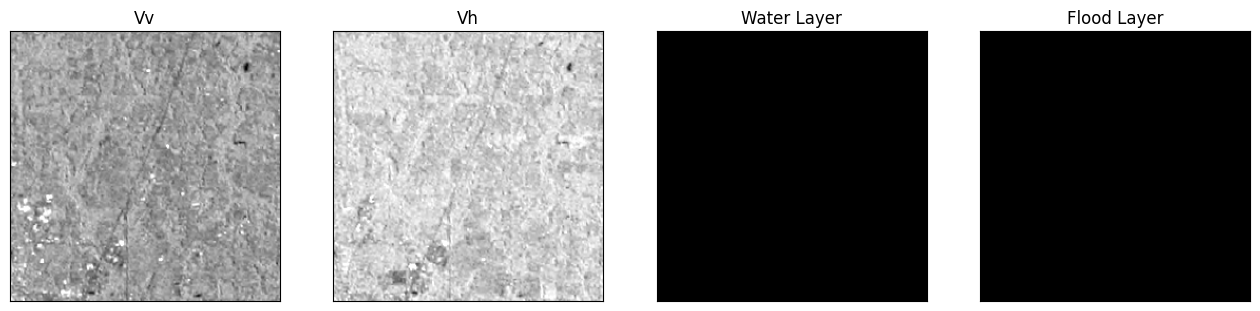

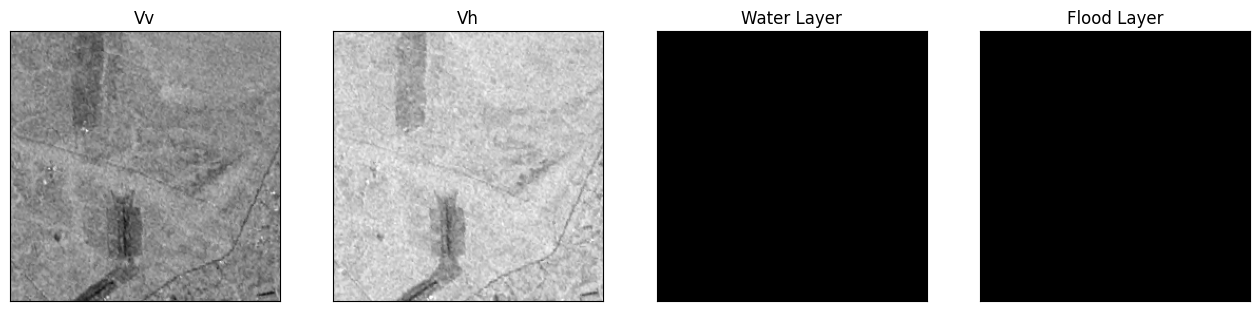

In [6]:
def show_datapoint(fpath):
    flood_layer = imread(fpath,0)
    vv = imread(cvtFpath(fpath, 'vv'),0)
    vh = imread(cvtFpath(fpath, 'vh'),0)
    water_layer = imread(cvtFpath(fpath, 'water_body_label'),0)
    visualize(vv=vv, vh=vh, water_layer=water_layer, flood_layer=flood_layer)

show_datapoint(train_paths[0])
show_datapoint(train_paths[np.random.randint(len(train_paths))])
show_datapoint(val_paths[np.random.randint(len(val_paths))])

In [7]:
import tensorflow.keras as keras

# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations."""

    def __init__(self, train_paths, classes=None, augmentation=None, preprocessing=None):
        self.CLASSES = classes  # Set the classes attribute here
        self.ids = train_paths
        self.masks_fps = train_paths
        self.wl_fps = [cvtFpath(fpath, 'water_body_label') for fpath in self.masks_fps]
        self.vv_fps = [cvtFpath(fpath, 'vv') for fpath in self.masks_fps]
        self.vh_fps = [cvtFpath(fpath, 'vh') for fpath in self.masks_fps]

        # Convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]

        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):
        # Read data
        vv = imread(self.vv_fps[i], as_gray=True)
        vh = imread(self.vh_fps[i], as_gray=True)
        wl = imread(self.wl_fps[i], as_gray=True)

        image = np.zeros((vv.shape[0], vv.shape[1], 3))
        image[:,:, 0] = vv
        image[:,:, 1] = vh
        image[:,:, 2] = wl

        mask = imread(self.masks_fps[i], as_gray=True)

        # Extract certain classes from the mask (e.g., flood)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')

        # Add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)

        # Apply augmentations if any
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # Apply preprocessing if any
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        return len(self.ids)


# class Dataset:
#     """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.

#     Args:
#         images_dir (str): path to images folder
#         masks_dir (str): path to segmentation masks folder
#         class_values (list): values of classes to extract from segmentation mask
#         augmentation (albumentations.Compose): data transfromation pipeline
#             (e.g. flip, scale, etc.)
#         preprocessing (albumentations.Compose): data preprocessing
#             (e.g. noralization, shape manipulation, etc.)

#     """

#     CLASSES = ['nodetect', 'flood']

#     def __init__(
#             self,
#             train_paths,
#             classes=None,
#             augmentation=None,
#             preprocessing=None,
#     ):
#         self.ids = train_paths
#         self.masks_fps = train_paths
#         self.wl_fps = [cvtFpath(fpath, 'water_body_label') for fpath in self.masks_fps]
#         self.vv_fps = [cvtFpath(fpath, 'vv') for fpath in self.masks_fps]
#         self.vh_fps = [cvtFpath(fpath, 'vh') for fpath in self.masks_fps]

#         # convert str names to class values on masks
#         self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]

#         self.augmentation = augmentation
#         self.preprocessing = preprocessing

#     def __getitem__(self, i):

#         # read data
#         vv = imread(self.vv_fps[i], as_gray=True)
#         vh = imread(self.vh_fps[i], as_gray=True)
#         wl = imread(self.wl_fps[i], as_gray=True)

#         image = np.zeros((vv.shape[0], vv.shape[1], 3))
#         image[:,:, 0] = vv
#         image[:,:, 1] = vh
#         image[:,:, 2] = wl

#         mask = imread(self.masks_fps[i], as_gray=True)

#         # extract certain classes from mask (e.g. cars)
#         masks = [(mask == v) for v in self.class_values]
#         mask = np.stack(masks, axis=-1).astype('float')

#         # add background if mask is not binary
#         if mask.shape[-1] != 1:
#             background = 1 - mask.sum(axis=-1, keepdims=True)
#             mask = np.concatenate((mask, background), axis=-1)

#         # apply augmentations
#         if self.augmentation:
#             sample = self.augmentation(image=image, mask=mask)
#             image, mask = sample['image'], sample['mask']

#         # apply preprocessing
#         if self.preprocessing:
#             sample = self.preprocessing(image=image, mask=mask)
#             image, mask = sample['image'], sample['mask']

#         return image, mask

#     def __len__(self):
#         return len(self.ids)


class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches

    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """

    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):

        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]

        return batch[0], batch[1]

    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

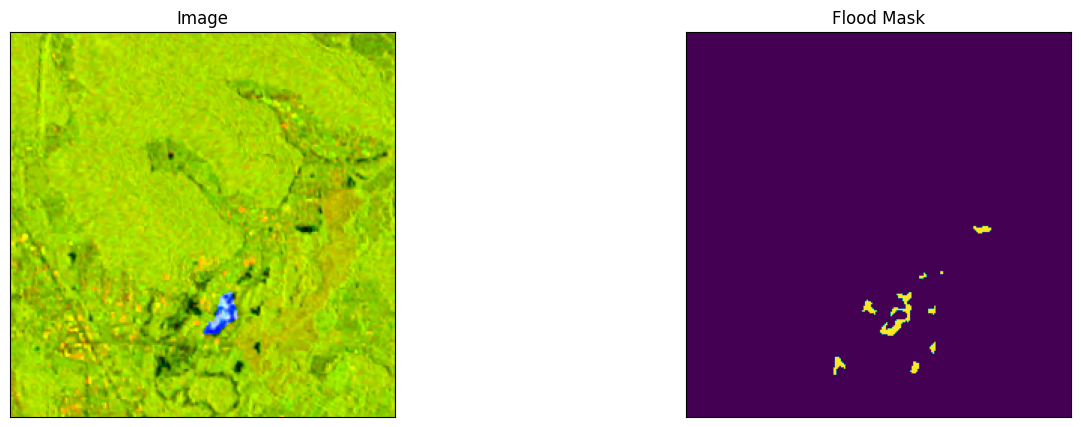

In [8]:
# Lets look at data we have
dataset = Dataset(train_paths, classes=['nodetect', 'flood'])

image, mask = dataset[2] # get some sample
visualize(
    image=image,
    flood_mask=mask[..., 1].squeeze(),
)

In [9]:
%env SM_FRAMEWORK=tf.keras
!pip install segmentation_models

import segmentation_models as sm

!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

import albumentations as A

import tensorflow as tf
tf.config.run_functions_eagerly(True)

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.
  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-4ws9ty3g
  Running command git clone --filter=blob:none --quiet https://github.com/albu/albumentations /tmp/pip-req-build-4ws9ty3g
  Resolved https://github.com/albu/albumentations to commit c6d4a4d92008b744d3a6767a9a3183e3a735c1dc
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [10]:
# Preprocessing Function
IMG_SIZE = 256

def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

def normalize_albumenation(x, **kwargs):
    return x

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=IMG_SIZE, min_width=IMG_SIZE, always_apply=True, border_mode=0),
        A.RandomCrop(height=IMG_SIZE, width=IMG_SIZE, always_apply=True),

        A.IAAAdditiveGaussianNoise(p=0.2),
        # A.IAAPerspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        # A.OneOf(
        #     [
        #         A.IAASharpen(p=1),
        #         A.Blur(blur_limit=3, p=1),
        #         A.MotionBlur(blur_limit=3, p=1),
        #     ],
        #     p=0.9,
        # ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
                      #  A.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        A.RandomCrop(height=IMG_SIZE, width=IMG_SIZE, always_apply=True)
        # A.PadIfNeeded(384, 480)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform

    Args:
        preprocessing_fn (callbale): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose

    """

    _transform = [
        A.Lambda(image=preprocessing_fn),
        A.Lambda(image=normalize_albumenation)
    ]
    return A.Compose(_transform)

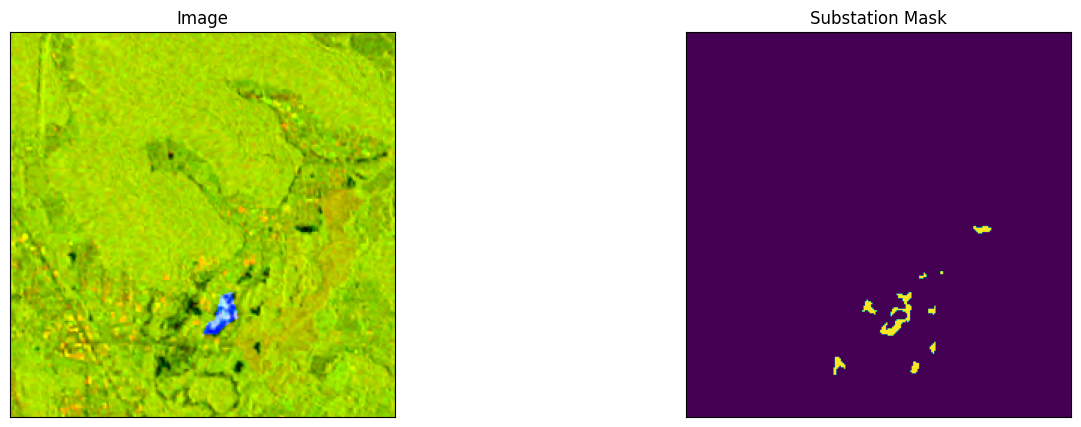

In [11]:
#  Lets look at augmented data we have
dataset = Dataset(train_paths, classes=['nodetect', 'flood'], preprocessing=get_preprocessing(None))

image, mask = dataset[2] # get some sample
visualize(
    image=image,
    substation_mask=mask[..., 1].squeeze(),
)

In [ ]:
# BACKBONE = 'resnet34'
# BATCH_SIZE = 50
# CLASSES = ['flood']
# LR = 0.0001
# EPOCHS = 150
# version = 8

# preprocess_input = sm.get_preprocessing(BACKBONE)

In [ ]:
# # define network parameters
# n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
# activation = 'sigmoid' if n_classes == 1 else 'softmax'

# tf.keras.backend.clear_session()
# #create mode
# # model = sm.PSPNet(BACKBONE, classes=n_classes, activation=activation)
# # model = sm.FPN(BACKBONE, classes=n_classes, activation=activation)
# model = sm.Unet(BACKBONE, classes=n_classes, activation=activation, encoder_weights=None) #'imagenet')#, encoder_freeze=True)
# # model = sm.Unet( classes=n_classes, activation=activation)

In [ ]:
# # define optomizer
# optim = keras.optimizers.Adam(LR)

# # Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# dice_loss = sm.losses.DiceLoss()
# focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
# jacard_loss = sm.losses.JaccardLoss()

# # total_loss =dice_loss + (1*focal_loss) + (1*jacard_loss) + (1*bce_loss)
# total_loss = dice_loss+jacard_loss+focal_loss


# # actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# # total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss

# metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# # compile keras model with defined optimozer, loss and metrics
# model.compile(optim, total_loss, metrics)

In [12]:
os.makedirs('/kaggle/working/', exist_ok=True)

In [ ]:
CUDA_LAUNCH_BLOCKING=1

import torch
from monai.networks.nets import UNETR
from monai.transforms import Compose, Transform
from monai.losses import DiceCELoss
from monai.data import DataLoader, Dataset
from monai.transforms import (
    LoadImageD,
    ScaleIntensityD,
    ToTensorD,
)
import numpy as np
from PIL import Image
import os
import torch.optim as optim

# Define constants and parameters
BACKBONE = 'UNETR'
BATCH_SIZE = 16
CLASSES = ['flood']
LR = 0.0001
EPOCHS = 150
IMG_SIZE = (256, 256)
device = torch.device("cuda")

def prepare_data_dicts(paths):
    """
    Create proper data dictionaries for MONAI Dataset with path verification
    """
    data_dicts = []
    for label_path in paths:
        vv_path = cvtFpath(label_path, 'vv')
        vh_path = cvtFpath(label_path, 'vh')
        label_path = cvtFpath(label_path, 'flood_label')

        # Verify all files exist
        if not all(os.path.exists(p) for p in [vv_path, vh_path, label_path]):
            continue

        data_dict = {
            "image": [vv_path, vh_path],
            "label": label_path
        }
        data_dicts.append(data_dict)

    if not data_dicts:
        raise ValueError("No valid data paths found!")

    return data_dicts

# Initialize UNETR model
model = UNETR(
    in_channels=2,
    out_channels=2,
    img_size=IMG_SIZE,
    feature_size=16,
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    norm_name="instance",
    dropout_rate=0.0,
    spatial_dims=2,
).to(device)

# Define loss function and optimizer
loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
optimizer = optim.Adam(model.parameters(), lr=LR)

class CombineChannelsD(Transform):
    def __init__(self, keys=["image"]):
        self.keys = keys

    def __call__(self, data):
        try:
            for key in self.keys:
                if isinstance(data[key], list):
                    # Load VV image
                    vv_img = np.array(Image.open(data[key][0])).astype(float)
                    if vv_img.ndim == 3:  # If RGB, convert to grayscale
                        vv_img = vv_img.mean(axis=-1)

                    # Load VH image
                    vh_img = np.array(Image.open(data[key][1])).astype(float)
                    if vh_img.ndim == 3:  # If RGB, convert to grayscale
                        vh_img = vh_img.mean(axis=-1)

                    # Resize
                    vv_img = np.array(Image.fromarray(vv_img.astype(np.uint8)).resize(IMG_SIZE))
                    vh_img = np.array(Image.fromarray(vh_img.astype(np.uint8)).resize(IMG_SIZE))

                    # Stack as channels (ensure 2D arrays are stacked)
                    data[key] = np.stack([vv_img, vh_img], axis=0)
                    # print(f"Image stack shape: {data[key].shape}")  # Should be (2, 256, 256)

        except Exception as e:
            print(f"Error in CombineChannelsD: {str(e)}")
            raise
        return data

class ConvertLabelD(Transform):
    def __init__(self, keys=["label"]):
        self.keys = keys

    def __call__(self, data):
        try:
            for key in self.keys:
                if isinstance(data[key], str):
                    # Load label image from file path
                    label_img = np.array(Image.open(data[key]))
                elif isinstance(data[key], np.ndarray):
                    # Use the provided numpy array directly
                    label_img = data[key]
                else:
                    raise ValueError(f"Unsupported data type for key {key}: {type(data[key])}")

                # Convert to grayscale if RGB
                if label_img.ndim == 3:
                    label_img = label_img.mean(axis=-1)

                # Resize label
                label_img = np.array(Image.fromarray(label_img.astype(np.uint8)).resize(IMG_SIZE, Image.NEAREST))

                # Convert to binary mask
                label_mask = (label_img > 128).astype(float)

                # Add channel dimension
                data[key] = label_mask[None, ...]
                # print(f"Label shape: {data[key].shape}")  # Should be (1, 256, 256)

        except Exception as e:
            print(f"Error in ConvertLabelD: {str(e)}")
            raise
        return data


# Define MONAI transforms for preprocessing
transforms = Compose([
    CombineChannelsD(keys=["image"]),
    ConvertLabelD(keys=["label"]),
    ScaleIntensityD(keys=["image"]),
    ToTensorD(keys=["image", "label"]),
])

def test_paths(paths):
    print("\nTesting file paths...")
    sample_path = paths[0]
    vv_path = cvtFpath(sample_path, 'vv')
    vh_path = cvtFpath(sample_path, 'vh')
    label_path = cvtFpath(sample_path, 'flood_label')

    print(f"Sample paths generated:")
    print(f"VV: {vv_path}")
    print(f"VH: {vh_path}")
    print(f"Label: {label_path}")

    print("\nChecking file existence:")
    print(f"VV exists: {os.path.exists(vv_path)}")
    print(f"VH exists: {os.path.exists(vh_path)}")
    print(f"Label exists: {os.path.exists(label_path)}")

    if os.path.exists(vv_path):
        img = Image.open(vv_path)
        print(f"VV image size: {img.size}")
    if os.path.exists(vh_path):
        img = Image.open(vh_path)
        print(f"VH image size: {img.size}")
    if os.path.exists(label_path):
        img = Image.open(label_path)
        print(f"Label image size: {img.size}")

def create_data_loaders(train_paths, val_paths):
    try:
        train_files = prepare_data_dicts(train_paths)
        val_files = prepare_data_dicts(val_paths)

        print(f"Number of training samples: {len(train_files)}")
        print(f"Number of validation samples: {len(val_files)}")

        train_dataset = Dataset(data=train_files, transform=transforms)
        valid_dataset = Dataset(data=val_files, transform=transforms)

        # Test loading a single sample
        print("\nTesting sample loading...")
        sample = train_dataset[0]
        # print(f"Sample image shape: {sample['image'].shape}")
        # print(f"Sample label shape: {sample['label'].shape}")

        train_dataloader = DataLoader(
            train_dataset,
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=0,
            pin_memory=True
        )
        valid_dataloader = DataLoader(
            valid_dataset,
            batch_size=BATCH_SIZE,
            shuffle=False,
            num_workers=0,
            pin_memory=True
        )

        return train_dataloader, valid_dataloader

    except Exception as e:
        print(f"Error in create_data_loaders: {str(e)}")
        raise

def train_model(model, train_dataloader, valid_dataloader, version="1"):
    loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
    optimizer = optim.Adam(model.parameters(), lr=LR)
    best_val_loss = float('inf')

    for epoch in range(EPOCHS):
        print(f"Epoch {epoch + 1}/{EPOCHS}")

        # Training phase
        model.train()
        epoch_loss = 0
        for batch_idx, batch in enumerate(train_dataloader):
            inputs, labels = batch["image"].to(device), batch["label"].to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            if batch_idx % 10 == 0:
                print(f"Batch {batch_idx}/{len(train_dataloader)}, "
                      f"Loss: {loss.item():.4f}")

        avg_train_loss = epoch_loss / len(train_dataloader)
        print(f"Training Loss: {avg_train_loss:.4f}")

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in valid_dataloader:
                inputs, labels = batch["image"].to(device), batch["label"].to(device)
                outputs = model(inputs)
                loss = loss_function(outputs, labels)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(valid_dataloader)
        print(f"Validation Loss: {avg_val_loss:.4f}")

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
            }, f"best_model_v{version}.pth")

# Usage example:
try:
    train_paths = get_train_datapath()
    val_paths = get_val_datapath()
    train_dataloader, valid_dataloader = create_data_loaders(train_paths, val_paths)
    train_model(model, train_dataloader, valid_dataloader)

except Exception as e:
    print(f"Error during execution: {str(e)}")
    raise

Number of training samples: 1000
Number of validation samples: 100

Testing sample loading...
Epoch 1/150
Batch 0/63, Loss: 1.1102
Batch 10/63, Loss: 1.0310
Batch 20/63, Loss: 0.9807
Batch 30/63, Loss: 0.9533
Batch 40/63, Loss: 0.9064
Batch 50/63, Loss: 0.8799
Batch 60/63, Loss: 0.8733
Training Loss: 0.9481
Validation Loss: 0.8805
Epoch 2/150
Batch 0/63, Loss: 0.8704
Batch 10/63, Loss: 0.8564
Batch 20/63, Loss: 0.8416
Batch 30/63, Loss: 0.8179
Batch 40/63, Loss: 0.8070
Batch 50/63, Loss: 0.7914
Batch 60/63, Loss: 0.7737
Training Loss: 0.8203
Validation Loss: 0.7845
Epoch 3/150
Batch 0/63, Loss: 0.7742
Batch 10/63, Loss: 0.7655
Batch 20/63, Loss: 0.7569
Batch 30/63, Loss: 0.7470
Batch 40/63, Loss: 0.7343
Batch 50/63, Loss: 0.7299
Batch 60/63, Loss: 0.7148
Training Loss: 0.7467
Validation Loss: 0.7250
Epoch 4/150
Batch 0/63, Loss: 0.7208
Batch 10/63, Loss: 0.7130
Batch 20/63, Loss: 0.7046
Batch 30/63, Loss: 0.6982


In [18]:
import torch
from monai.networks.nets import UNETR
from monai.transforms import Compose, Transform
from monai.losses import DiceCELoss
from monai.data import DataLoader, Dataset
from monai.transforms import (
    LoadImageD,
    ScaleIntensityD,
    ToTensorD,
)
import numpy as np
from PIL import Image
import os
import torch.optim as optim

# Define constants and parameters
BACKBONE = 'UNETR'
BATCH_SIZE = 16
CLASSES = ['flood']
LR = 0.0001
EPOCHS = 150
IMG_SIZE = (256, 256)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def prepare_data_dicts(paths):
    """
    Create proper data dictionaries for MONAI Dataset with path verification
    """
    data_dicts = []
    for label_path in paths:
        vv_path = cvtFpath(label_path, 'vv')
        vh_path = cvtFpath(label_path, 'vh')
        label_path = cvtFpath(label_path, 'flood_label')

        # Verify all files exist
        if not all(os.path.exists(p) for p in [vv_path, vh_path, label_path]):
            continue

        data_dict = {
            "image": [vv_path, vh_path],
            "label": label_path
        }
        data_dicts.append(data_dict)

    if not data_dicts:
        raise ValueError("No valid data paths found!")

    return data_dicts

# Initialize UNETR model
model = UNETR(
    in_channels=2,
    out_channels=2,
    img_size=IMG_SIZE,
    feature_size=16,
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    norm_name="instance",
    dropout_rate=0.0,
    spatial_dims=2,
).to(device).float()  # Explicitly set to float

# Define loss function and optimizer
loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
optimizer = optim.Adam(model.parameters(), lr=LR)

class CombineChannelsD(Transform):
    def __init__(self, keys=["image"]):
        self.keys = keys

    def __call__(self, data):
        try:
            for key in self.keys:
                if isinstance(data[key], list):
                    # Load VV image
                    vv_img = np.array(Image.open(data[key][0])).astype(np.float32)  # Changed to float32
                    if vv_img.ndim == 3:
                        vv_img = vv_img.mean(axis=-1)

                    # Load VH image
                    vh_img = np.array(Image.open(data[key][1])).astype(np.float32)  # Changed to float32
                    if vh_img.ndim == 3:
                        vh_img = vh_img.mean(axis=-1)

                    # Resize
                    vv_img = np.array(Image.fromarray(vv_img.astype(np.uint8)).resize(IMG_SIZE))
                    vh_img = np.array(Image.fromarray(vh_img.astype(np.uint8)).resize(IMG_SIZE))

                    # Stack as channels and convert to float32
                    data[key] = np.stack([vv_img, vh_img], axis=0).astype(np.float32)
                    print(f"Image stack shape: {data[key].shape}")

        except Exception as e:
            print(f"Error in CombineChannelsD: {str(e)}")
            raise
        return data

class ConvertLabelD(Transform):
    def __init__(self, keys=["label"]):
        self.keys = keys

    def __call__(self, data):
        try:
            for key in self.keys:
                label_data = data[key]

                if isinstance(label_data, (str, os.PathLike)):
                    label_img = np.array(Image.open(label_data))
                elif isinstance(label_data, np.ndarray):
                    label_img = label_data
                else:
                    raise ValueError(f"Unsupported label data type: {type(label_data)}")

                if label_img.ndim == 3:
                    label_img = label_img.mean(axis=-1)

                label_img = np.array(Image.fromarray(label_img.astype(np.uint8)).resize(IMG_SIZE, Image.NEAREST))
                label_mask = (label_img > 128).astype(np.float32)  # Changed to float32
                data[key] = label_mask[None, ...]
                print(f"Label shape: {data[key].shape}")

        except Exception as e:
            print(f"Error in ConvertLabelD: {str(e)}")
            raise
        return data

# Define MONAI transforms for preprocessing
transforms = Compose([
    CombineChannelsD(keys=["image"]),
    ConvertLabelD(keys=["label"]),
    ScaleIntensityD(keys=["image"]),
    ToTensorD(keys=["image", "label"]),
])

def test_paths(paths):
    print("\nTesting file paths...")
    sample_path = paths[0]
    vv_path = cvtFpath(sample_path, 'vv')
    vh_path = cvtFpath(sample_path, 'vh')
    label_path = cvtFpath(sample_path, 'flood_label')

    print(f"Sample paths generated:")
    print(f"VV: {vv_path}")
    print(f"VH: {vh_path}")
    print(f"Label: {label_path}")

    print("\nChecking file existence:")
    print(f"VV exists: {os.path.exists(vv_path)}")
    print(f"VH exists: {os.path.exists(vh_path)}")
    print(f"Label exists: {os.path.exists(label_path)}")

    if os.path.exists(vv_path):
        img = Image.open(vv_path)
        print(f"VV image size: {img.size}")
    if os.path.exists(vh_path):
        img = Image.open(vh_path)
        print(f"VH image size: {img.size}")
    if os.path.exists(label_path):
        img = Image.open(label_path)
        print(f"Label image size: {img.size}")

def create_data_loaders(train_paths, val_paths):
    try:
        train_files = prepare_data_dicts(train_paths)
        val_files = prepare_data_dicts(val_paths)

        print(f"Number of training samples: {len(train_files)}")
        print(f"Number of validation samples: {len(val_files)}")

        train_dataset = Dataset(data=train_files, transform=transforms)
        valid_dataset = Dataset(data=val_files, transform=transforms)

        # Test loading a single sample
        print("\nTesting sample loading...")
        sample = train_dataset[0]
        print(f"Sample image shape: {sample['image'].shape}")
        print(f"Sample label shape: {sample['label'].shape}")
        print(f"Sample image dtype: {sample['image'].dtype}")
        print(f"Sample label dtype: {sample['label'].dtype}")

        train_dataloader = DataLoader(
            train_dataset,
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=0,
            pin_memory=True
        )
        valid_dataloader = DataLoader(
            valid_dataset,
            batch_size=BATCH_SIZE,
            shuffle=False,
            num_workers=0,
            pin_memory=True
        )

        return train_dataloader, valid_dataloader

    except Exception as e:
        print(f"Error in create_data_loaders: {str(e)}")
        raise

def train_model(model, train_dataloader, valid_dataloader, version="1"):
    loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
    optimizer = optim.Adam(model.parameters(), lr=LR)
    best_val_loss = float('inf')

    for epoch in range(EPOCHS):
        print(f"Epoch {epoch + 1}/{EPOCHS}")

        # Training phase
        model.train()
        epoch_loss = 0
        for batch_idx, batch in enumerate(train_dataloader):
            try:
                # Ensure data types are correct before moving to GPU
                inputs = batch["image"].float().to(device)
                labels = batch["label"].float().to(device)

                # Print shapes and types for debugging
                if batch_idx == 0:
                    print(f"Input shape: {inputs.shape}, dtype: {inputs.dtype}")
                    print(f"Label shape: {labels.shape}, dtype: {labels.dtype}")

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = loss_function(outputs, labels)

                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()

                if batch_idx % 10 == 0:
                    print(f"Batch {batch_idx}/{len(train_dataloader)}, "
                          f"Loss: {loss.item():.4f}")

            except RuntimeError as e:
                print(f"Error in batch {batch_idx}: {str(e)}")
                print(f"Input shape: {inputs.shape}, dtype: {inputs.dtype}")
                print(f"Label shape: {labels.shape}, dtype: {labels.dtype}")
                raise

        avg_train_loss = epoch_loss / len(train_dataloader)
        print(f"Training Loss: {avg_train_loss:.4f}")

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in valid_dataloader:
                inputs = batch["image"].float().to(device)
                labels = batch["label"].float().to(device)
                outputs = model(inputs)
                loss = loss_function(outputs, labels)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(valid_dataloader)
        print(f"Validation Loss: {avg_val_loss:.4f}")

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
            }, f"best_model_v{version}.pth")

# Usage example:
try:
    # Set CUDA to synchronous mode for better error reporting
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True

    train_paths = get_train_datapath()
    val_paths = get_val_datapath()
    train_dataloader, valid_dataloader = create_data_loaders(train_paths, val_paths)
    train_model(model, train_dataloader, valid_dataloader)

except Exception as e:
    print(f"Error during execution: {str(e)}")
    raise


RuntimeError: CUDA error: invalid argument
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
# # Dataset for train images
# train_dataset = Dataset( train_paths,
#     classes=CLASSES,
# #     augmentation=get_training_augmentation(),
# #     preprocessing=get_preprocessing(preprocess_input),
# )

# # Dataset for validation images
# valid_dataset = Dataset(
#     val_paths,
#     classes=CLASSES,
# #     augmentation=get_validation_augmentation(),
# #     preprocessing=get_preprocessing(preprocess_input),
# )

# train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# valid_dataloader = Dataloder(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)

# # check shapes for errors
# assert train_dataloader[0][0].shape == (BATCH_SIZE, IMG_SIZE, IMG_SIZE, 3)
# assert train_dataloader[0][1].shape == (BATCH_SIZE, IMG_SIZE, IMG_SIZE, n_classes)

# # define callbacks for learning rate scheduling and best checkpoints saving
# callbacks = [
#     keras.callbacks.ModelCheckpoint('/kaggle/working/best_model_v%d.weights.h5'%version, save_weights_only=True,save_best_only=True, mode='min', verbose=1),
#     keras.callbacks.ReduceLROnPlateau(factor=0.5, verbose=1),
# ]

# with open('/kaggle/working/ModelSummary_v%d.txt'%version, 'w') as f:
#   model.summary(print_fn=f.write)
# model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)         │ (None, None, None, 3)  │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_data                   │ (None, None, None, 3)  │              9 │ data[0][0]             │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, None, None, 3)  │              0 │ bn_data[0][0]          │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv0 (Conv2D)            │ (None, None, None, 64) │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn0 (BatchNormalization)  │ (None, None, None, 64) │            256 │ conv0[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ relu0 (Activation)        │ (None, None, None, 64) │              0 │ bn0[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, None, None, 64) │              0 │ relu0[0][0]            │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pooling0 (MaxPooling2D)   │ (None, None, None, 64) │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage1_unit1_bn1          │ (None, None, None, 64) │            256 │ pooling0[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage1_unit1_relu1        │ (None, None, None, 64) │              0 │ stage1_unit1_bn1[0][0] │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_2          │ (None, None, None, 64) │              0 │ stage1_unit1_relu1[0]… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage1_unit1_conv1        │ (None, None, None, 64) │         36,864 │ zero_padding2d_2[0][0] │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage1_unit1_bn2          │ (None, None, None, 64) │            256 │ stage1_unit1_conv1[0]… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage1_unit1_relu2        │ (None, None, None, 64) │              0 │ stage1_unit1_bn2[0][0] │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_3          │ (None, None, None, 64) │              0 │ stage1_unit1_relu2[0]… │
│ (ZeroPadding2D)      

 Total params: 24,456,154 (93.29 MB)

 Trainable params: 24,438,804 (93.23 MB)

 Non-trainable params: 17,350 (67.77 KB)

In [ ]:
# train model
history = model.fit(
    train_dataloader,
    steps_per_epoch=len(train_dataloader),
    epochs=EPOCHS,
    callbacks=callbacks,
    validation_data=valid_dataloader,
    validation_steps=len(valid_dataloader),
)

Epoch 1/150


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


TypeError: When providing the `loss_weights` argument, each element should be a Python int, float (the weighting coefficient corresponding to the loss for that output) or `None`.Received: loss_weights=[<segmentation_models.metrics.IOUScore object at 0x786ec84fe380>, <segmentation_models.metrics.FScore object at 0x786ec84fe3e0>]